<h1>MNIST Sequential OCR</h1>
<h3>An Hoang</h3>

<p>Using MNIST to compose a sequence of numbers to perform OCR with Connectionist Temporal Classification (CTC) is a good toy example to demonstrate a proof-of-concept that CTC can be used for building ASR systems. In this problem, an image is passed through a CNN in get out a stack of feature maps. We can think of these as resized images. We can scan these images from left to right and perform a sequential classification using a sequence-to-sequence model and a CTC cost function. Channels from the corresponding width will have to be stacked so they can be read in the time domain. Similarly in ASR, chunks of speech are processed into Mel Frequency Cepstral Coefficients (MFCCs), or more succinctly represented as spectrograms. Feature can be derived similarly as such representation, where the progression from left to right of a representative spectrogram is the time axis.</p>

In [1]:
from digits_gen import DataGenerator
from model import Embedding, Inference
from tensorflow import keras
from custom_plot import PlotLosses

<h3>Data Generator</h3>
<p>We initialize our custom batch data generator to produce a random sequence of numbers with length 8 and corresponding labels. Technically we can vary sequence length and then pad it to max length, but for simplicity's sake, we keep a consistent sequence length. The generator produces images by randomly sampling from the respective train and test data sets and shifts each image so that there is a small chance of overlap. This is an informal study, so we don't bother to make a train-validation-test split. Finally, the generator is passed to a tensorflow Dataset class to turn it into a tensor with labels that our network can understand.</p3>

In [2]:
# Set some initial parameters and calculate sequence image sizes
batch_size = 32
min_seq_len=8,
max_seq_len=8
w, h = 28*max_seq_len, 28

# Initialize our datagen to get out data
datagen = DataGenerator(min_seq_len=min_seq_len,
                        max_seq_len=max_seq_len,
                        batch_size=batch_size)

# Load in the original MNIST dataset from Keras
x_train, y_train = datagen.x_train, datagen.y_train
x_test, y_test = datagen.x_test, datagen.y_test

# Generate our sequence examples on the fly, in batches, and
# create the right tensorflow Dataset class format to feed into our training
train_data = datagen.tensor_batch(data = x_train,
                                  data_labels = y_train)
valid_data = datagen.tensor_batch(data = x_test,
                                  data_labels = y_test)

Loaded 60000 train images, and 10000 test images
Train array of shape (60000, 28, 28, 1)
batch_size set at 32, with digit len from (8,) to 8


<h3>CNN-LSTM Model</h3>
<p>The core idea behind CTC is to collapse a sequence of predictions for our sequence of numbers such as "11_111_222_33_444[]" into "11234". Characters not separated by "_" are collapsed into a single character. The square brackets represents a space (no characters). In our network, the sequences are consistently filled for simplicity, so spaces don't apply here. This problem resolves the fact that input into a seq-to-seq model might not match the shorter output required.</p>
<p>The first part of the network is a feature extractor formed by two convolutional blocks (conv, batch norm, relu, maxpool). The output is a stack of feature maps. Because we used two maxpool operations (maintaining 'same' padding), we reduce our original width and height by 4. The final image is in the shape of (batch_size, w//4, h//4, 64 filter channels). To prepare it for a seq-to-seq model, we have to reshape to the expected dimensions of (batch_size, timesteps, features). To do this, we just stack up the 64 filter channels with their corresponding width pixel. We can then drop in a dense layer to reduce the number of features before sending through to two stacked LSTM layers and our custom CTC prediction layer which utilizes the CTC batch cost function. This is then outputted to a logit layer with our number of classes plus one for a blank space.<p>

In [3]:
model = Embedding(w=w, h=h).ctc_compile()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batch_images (InputLayer)       [(None, 224, 28, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 28, 32)  320         batch_images[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 28, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 224, 28, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

<h3>Training</h3>
<p>Training is straightforward, we set our callbacks to stop early after 7 epochs of no improvements and add in a custom plotter to update our plot after every epoch. The end goal is to see a little bit of overfitting, then stop training. Due to time constraints, we will not train to the most optimal number of epochs. Here can we see that the validation loss is consistently lower than the training loss towards the end of the training, which means that we are underfitting; we can afford to keep training further to refine the learned weights. If we find that we are still significantly underfit, we can benefit from increasing the complexity of the network with more feature extractors, or a bi-directional LSTM. We are limited to how many feature extractors if we use max pool often due to the fact that the number of input sequences to our LSTM should exceed the label length.</p>

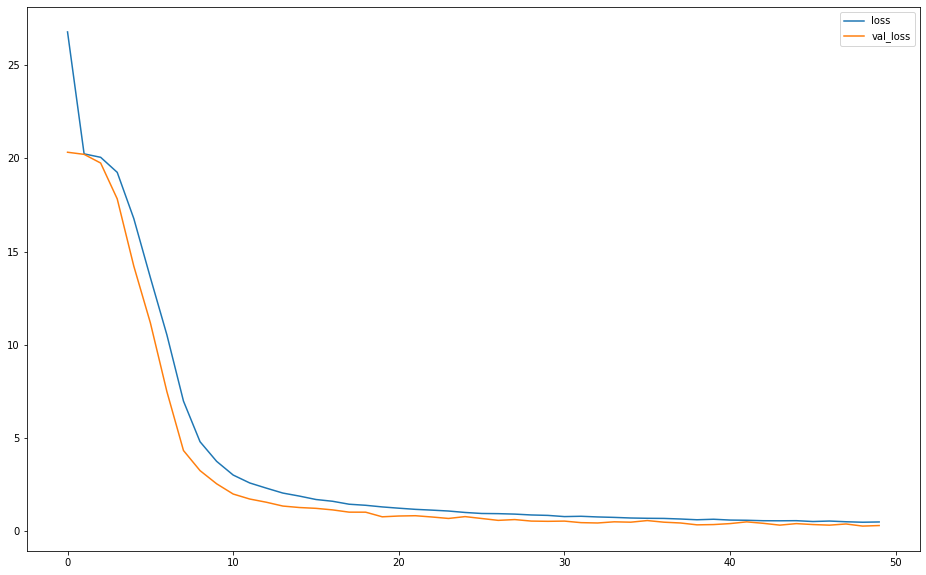

200/200 [==============================] - 5s 26ms/step - loss: 0.5025 - val_loss: 0.3101


In [4]:
# Because we are using generators, make sure to estimate how many train samples to train over
# We are sampling from 60k images to produce novel sequences each time, so we expect training
# loss to decrease for a while
batch_size = 32
train_samples = 32*200
validation_samples = 32*20
steps_per_epoch = train_samples//batch_size
valid_steps = validation_samples//batch_size
epochs = 50
early_stopping_patience = 7


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience = early_stopping_patience,
                                           restore_best_weights=True)
        
# We input a custom plot loss into the callback to see updated graph every epoch
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=valid_steps,
    callbacks=[early_stop, PlotLosses()]
)


Initializing generator of batch size 32


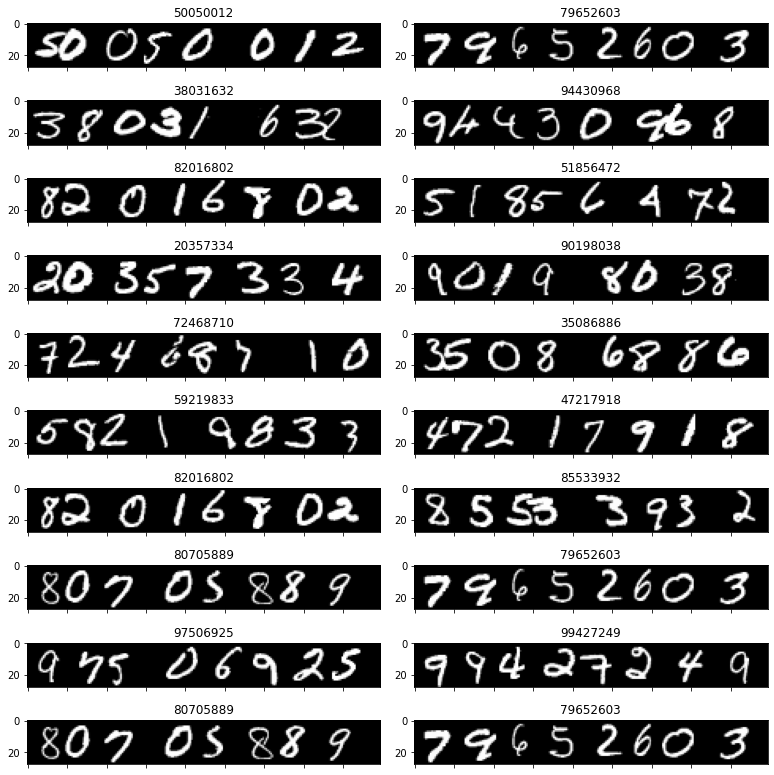

In [5]:
# Take a single batch and randomly plot preds for 20 of the samples
test_data = valid_data.take(1)

for batch in test_data:
    image_tensor = batch['image']
    label_tensor = batch['label']
    
    image = image_tensor.numpy()
    label = label_tensor.numpy()
    
    inference_model = Inference(model)
    preds = inference_model.predict(image_tensor, label_len=max_seq_len)
    datagen.plot_images(image, preds)

<h3>Improvements</h3>
<p>While using our CTC loss metric made it easy to see improvements in the model, additional metrics based on edit-distance (Levenshtein), such as the word error rate (W.E.R.) would help us have a better grasp of the errors relative to the lengths of our sequences. Clearly we can spend a significant amount of time performing hyperparameter tuning by plotting losses against learning rates and testing various decay functions to optimally train our network, or network architectures to improve on underfit training, and further image augmentation techniques given time. Additionally, we can modify our sequences to be of variable lengths and change calculations to accommodate that.<p>